In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
import env

# Probabilistic Methods (Discrete) Exercise


### Use basic probability to identify anomalous requests. Using the methods covered in this lesson, examine the rest of the features in the api access logs data set.

In [2]:
# acquire data
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/logs'
df = pd.read_sql('SELECT * FROM api_access', url)
# df = pd.concat([df.entry, df.entry.apply(parse_log_entry)], axis=1)
df = df.entry.apply(parse_log_entry)
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [3]:
# create some sythetic records and append them to our existing data frame

new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

df = df.append(new)

In [4]:
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [5]:
# convert to datetime and set as index

df['size_mb'] = df['size'] / 1024 / 1024
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13978 entries, 2019-04-16 19:34:42 to 2019-04-19 19:42:41
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ip              13978 non-null  object 
 1   request_method  13978 non-null  object 
 2   request_path    13978 non-null  object 
 3   http_version    13978 non-null  object 
 4   status_code     13978 non-null  object 
 5   size            13978 non-null  int64  
 6   user_agent      13978 non-null  object 
 7   size_mb         13978 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 982.8+ KB


In [7]:
df.describe()

,size,size_mb
count,1.397800e+04,13978.000000
mean,4.500019e+05,0.429155
std,1.614915e+05,0.154010
min,0.000000e+00,0.000000
25%,5.006370e+05,0.477445
50%,5.101380e+05,0.486506
75%,5.112910e+05,0.487605
max,2.056327e+06,1.961066


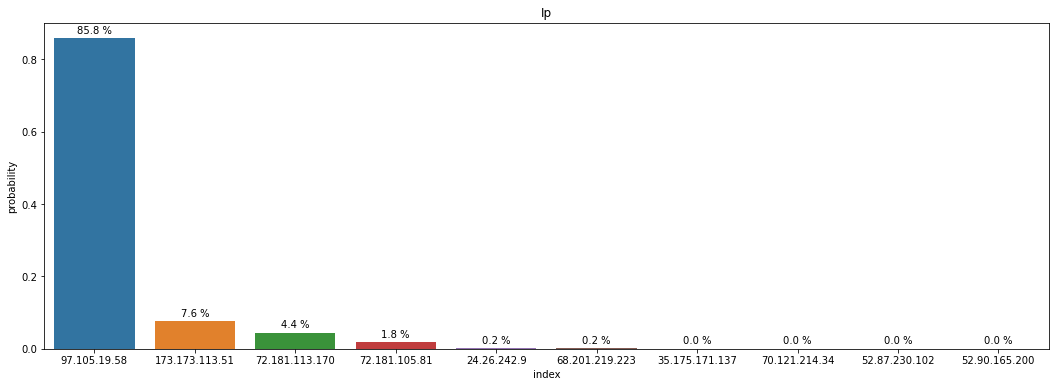

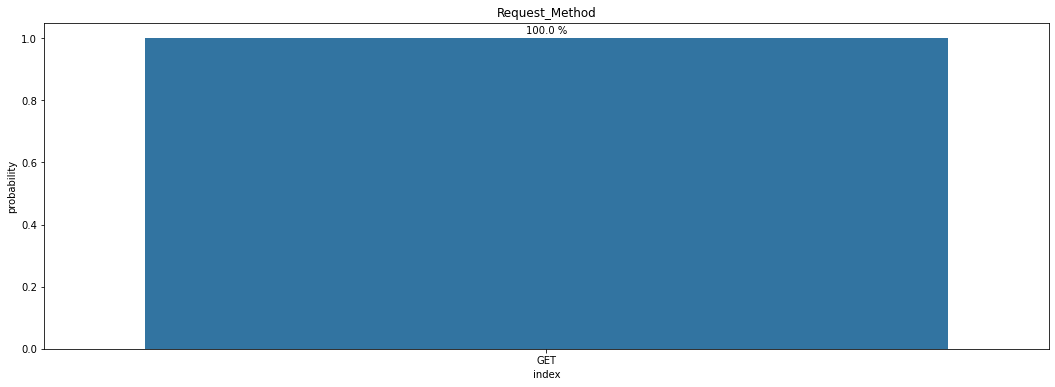

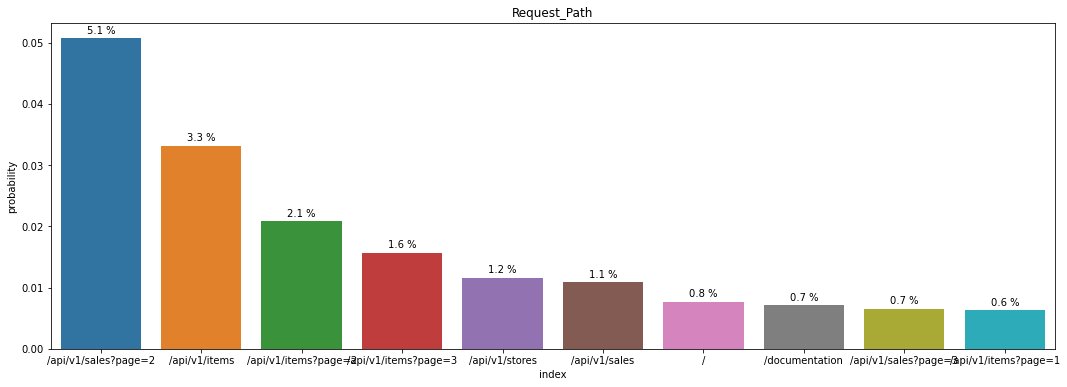

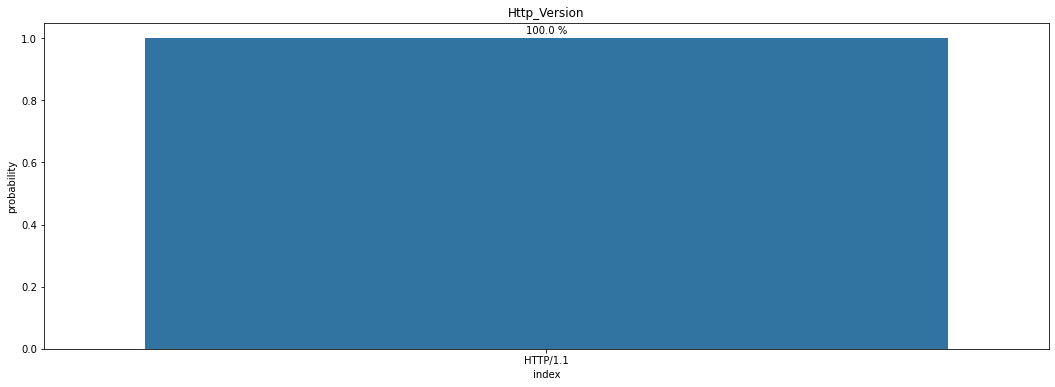

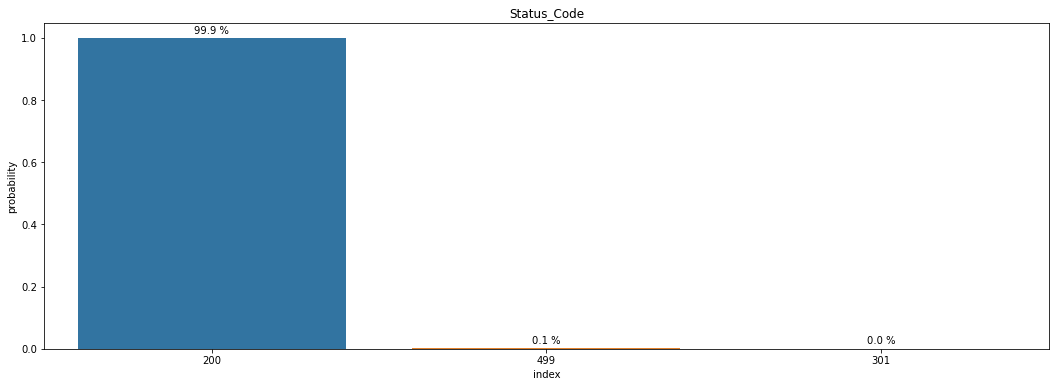

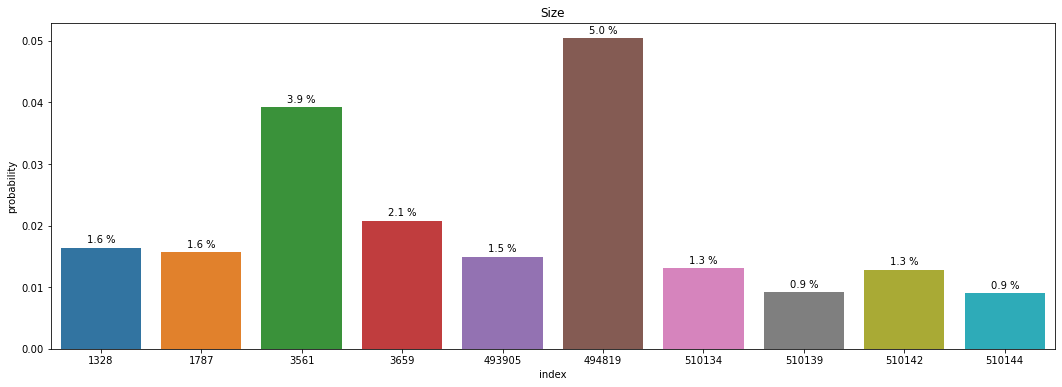

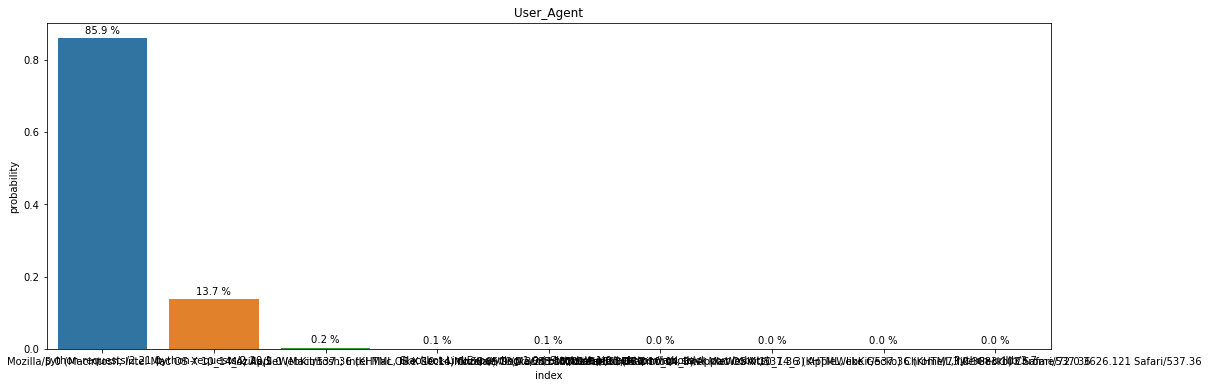

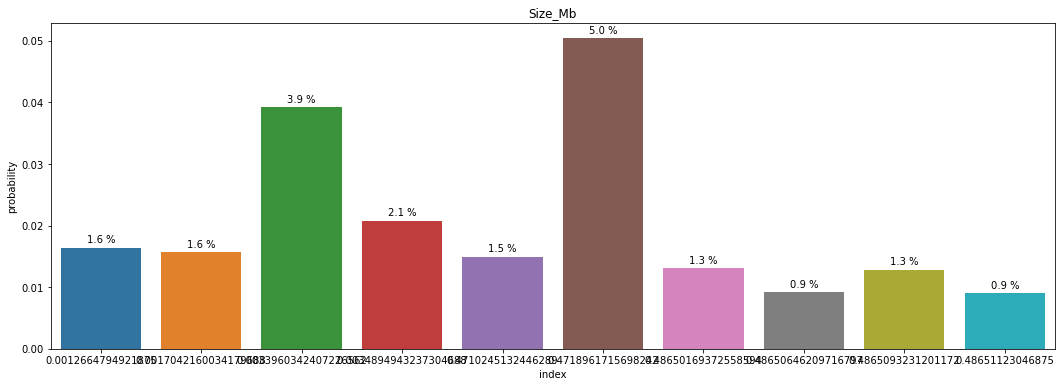

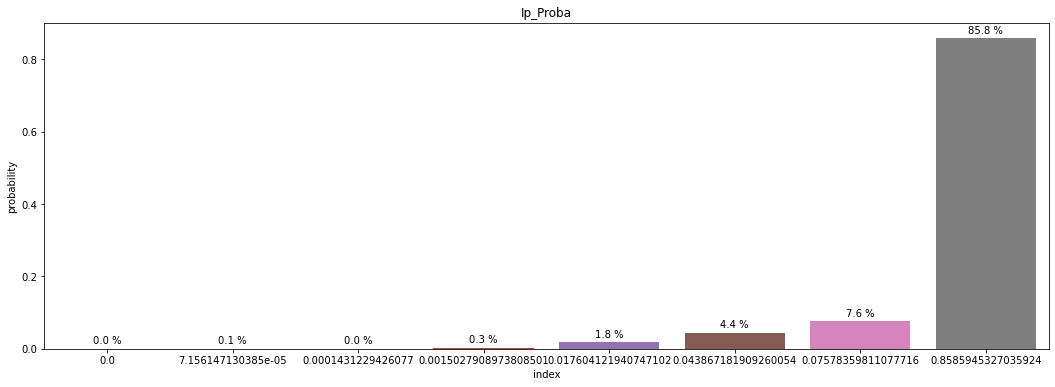

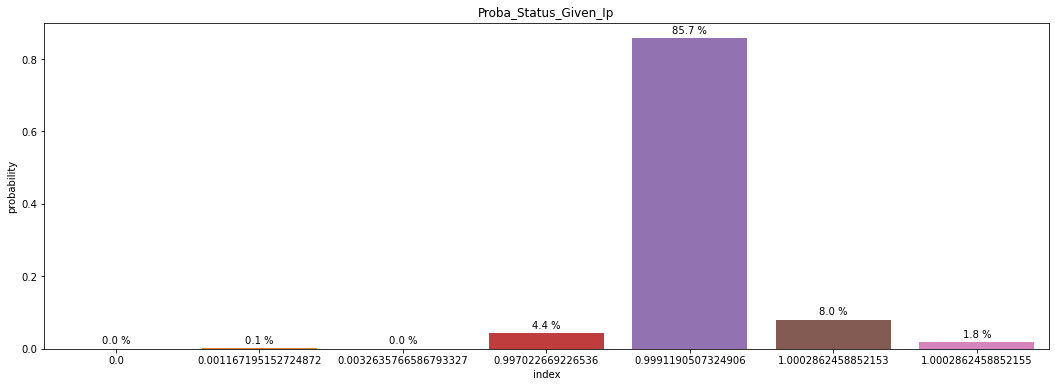

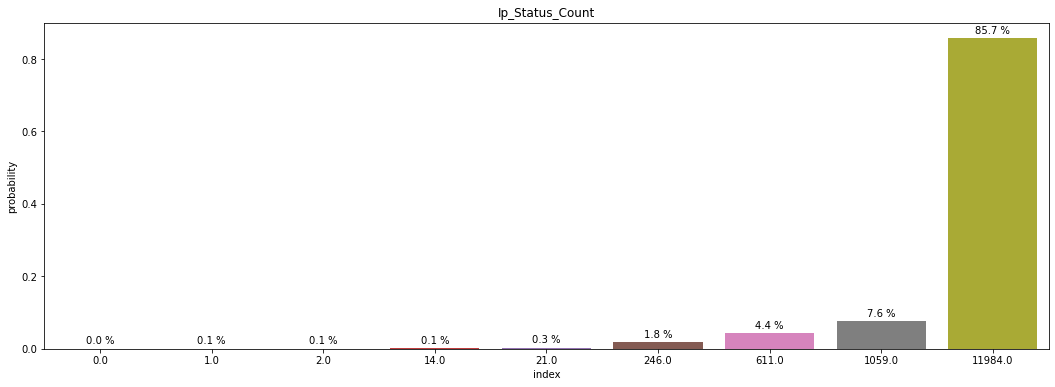

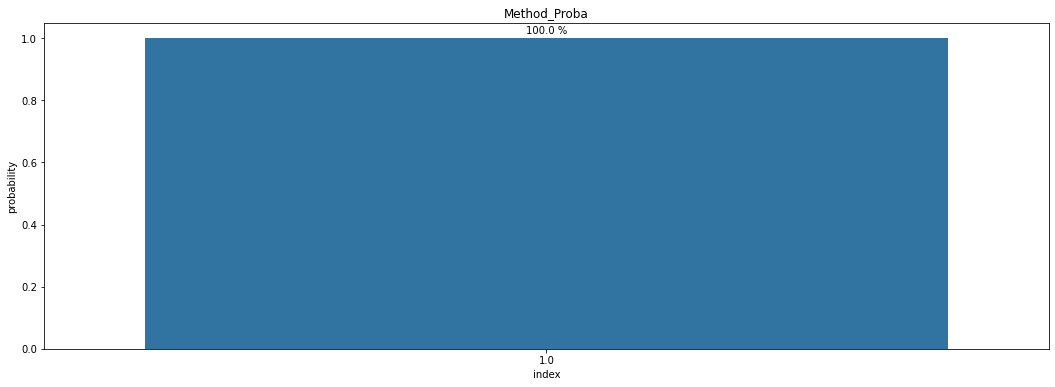

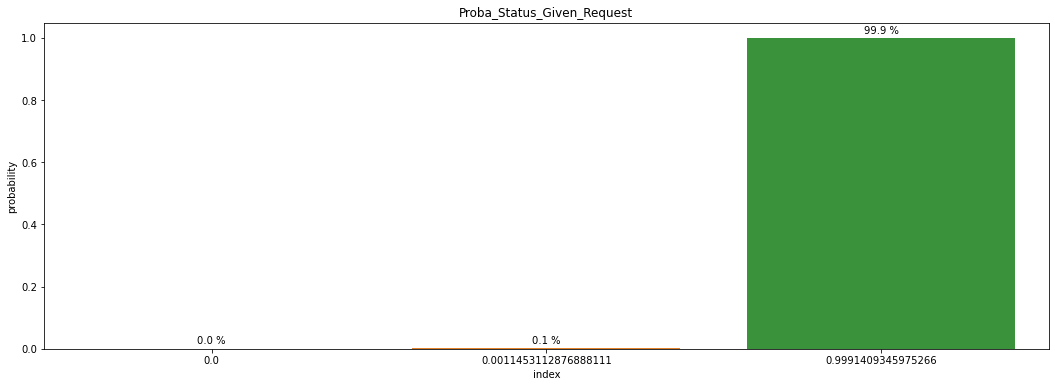

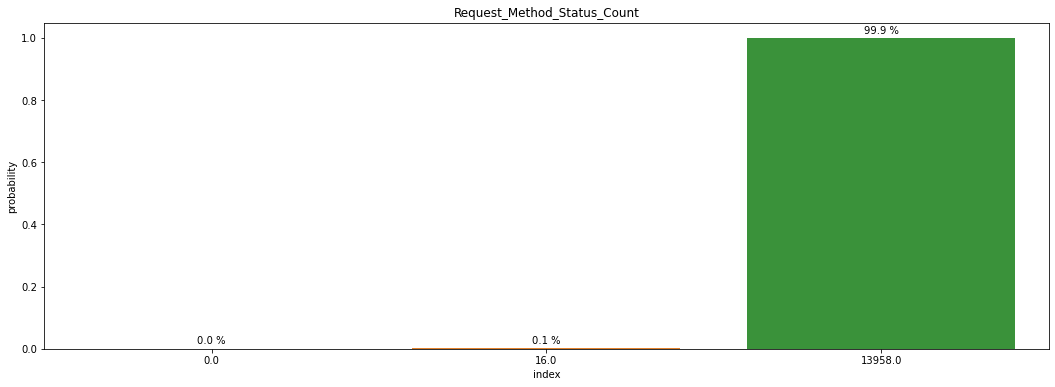

In [44]:
for col in df.columns:
    plt.figure(figsize=(18, 6))
    splot = sns.barplot(x='index', y=col, data=df[col].value_counts(normalize=True).reset_index().sort_values(
        by=col, ascending=False).head(10))
    for p in splot.patches:
        splot.annotate(format(p.get_height() * 100, '.1f') + ' %', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   xytext = (0, 8), 
                   textcoords = 'offset points')
    plt.title(col.title())
    plt.ylabel('probability')
    plt.show()

In [9]:
# got value counts of unique ips

ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(columns={'index': 'ip', 'ip': 'ip_count'})

In [10]:
ip_df.head()

,ip,ip_count
0,97.105.19.58,11999
1,173.173.113.51,1059
2,72.181.113.170,613
3,72.181.105.81,246
4,24.26.242.9,21


In [11]:
# found out probability of the ip being used

ip_df2 = pd.DataFrame(df.ip.value_counts(dropna = False)/df.ip.count()).reset_index().rename(index = str , columns = {'index':'ip','ip':'ip_proba'})

In [12]:
ip_df2

,ip,ip_proba
0,97.105.19.58,0.858420
1,173.173.113.51,0.075762
2,72.181.113.170,0.043855
3,72.181.105.81,0.017599
4,24.26.242.9,0.001502
5,68.201.219.223,0.001502
6,35.175.171.137,0.000143
7,70.121.214.34,0.000143
8,52.87.230.102,0.000143
9,52.91.30.150,0.000072


In [13]:
# merge the data sets to find out probability of a request being from one dataset

ip_df = ip_df.merge(ip_df2)

In [14]:
ip_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ip        22 non-null     object 
 1   ip_count  22 non-null     int64  
 2   ip_proba  22 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 704.0+ bytes


In [15]:
# merge probabilities df onto original df to get probability of each request happening

merged = df.merge(ip_df, on = 'ip', how = 'left')

In [16]:
# pull out probabilities less than 1%

merged[merged['ip_proba'] <= .01].groupby('ip').count()

,request_method,request_path,http_version,status_code,size,user_agent,size_mb,ip_count,ip_proba
ip,,,,,,,,,
24.26.242.9,21,21,21,21,21,21,21,21,21
3.88.129.158,1,1,1,1,1,1,1,1,1
3.92.201.136,1,1,1,1,1,1,1,1,1
34.207.64.242,1,1,1,1,1,1,1,1,1
34.229.70.250,1,1,1,1,1,1,1,1,1
35.174.209.2,1,1,1,1,1,1,1,1,1
35.175.171.137,2,2,2,2,2,2,2,2,2
45.23.250.16,1,1,1,1,1,1,1,1,1
52.87.230.102,2,2,2,2,2,2,2,2,2


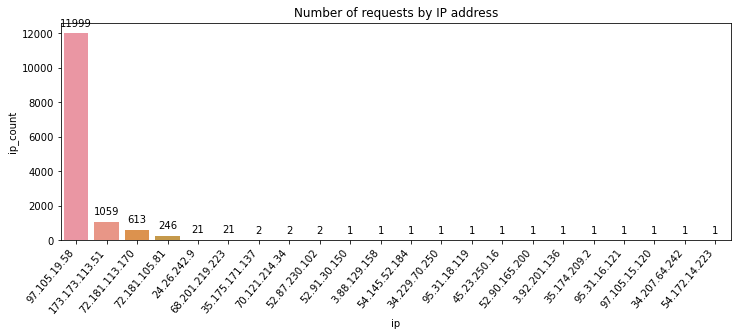

In [17]:
plt.figure(figsize=(12, 4))
splot = sns.barplot(data=ip_df, x = 'ip', y = 'ip_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation= 50, ha = 'right')
    plt.title('Number of requests by IP address')

In [18]:
# take a sample of one year

train = df.loc['2019-04-16 19:34:42':'2019-04-17 12:55:14']

In [19]:
# only of the columns we need

train = train[['ip','request_method','status_code','user_agent','size_mb']]

In [20]:
# find out the ip probability for train

ip_train = pd.DataFrame(train.ip.value_counts(dropna=False)/train.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})

In [21]:
# merge onto original dataframe to "predict" probabilities. fill nulls with 0 

df = df.reset_index().merge(ip_train, on=['ip'], how='left').fillna(value=0).set_index('timestamp')
df.ip_proba.value_counts()

0.858595    11999
0.075784     1059
0.043867      613
0.017604      246
0.001503       42
0.000072       10
0.000143        6
0.000000        3
Name: ip_proba, dtype: int64

In [22]:
# get ip probabilities for multi analysis

ip_probs = train.groupby('ip').size().div(len(df))

In [23]:
# group by ip and status, then get the probabilites and save the results in a column

status_given_ip = pd.DataFrame(train.groupby(['ip', 'status_code']).\
                               size().div(len(train)).\
                               div(ip_probs, 
                                   axis=0, 
                                   level='ip').\
                               reset_index().\
                               rename(index=str, 
                                      columns={0: 'proba_status_given_ip'})
                              )

In [43]:
status_given_ip

,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.000286
1,24.26.242.9,200,1.000286
2,3.88.129.158,200,1.000286
3,3.92.201.136,200,1.000286
4,34.207.64.242,200,1.000286
5,34.229.70.250,200,1.000286
6,35.174.209.2,200,1.000286
7,35.175.171.137,200,1.000286
8,45.23.250.16,200,1.000286
9,52.87.230.102,200,1.000286


In [25]:
# find out the status codes by IP counts

ip_status_count = pd.DataFrame(train.groupby(['ip', 'status_code'])['request_method'].\
                                count().reset_index().\
                                rename(index=str, 
                                       columns={'request_method': 'ip_status_count'}))

In [26]:
# merged ip status counts into the ip 

ip_status = status_given_ip.merge(ip_status_count)

In [27]:
# merge the status probability sets into the original df

df = df.reset_index().merge(ip_status, on=['ip', 'status_code'], how='left').fillna(value=0).set_index('timestamp')

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13978 entries, 2019-04-16 19:34:42 to 2019-04-19 19:42:41
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ip                     13978 non-null  object 
 1   request_method         13978 non-null  object 
 2   request_path           13978 non-null  object 
 3   http_version           13978 non-null  object 
 4   status_code            13978 non-null  object 
 5   size                   13978 non-null  int64  
 6   user_agent             13978 non-null  object 
 7   size_mb                13978 non-null  float64
 8   ip_proba               13978 non-null  float64
 9   proba_status_given_ip  13978 non-null  float64
 10  ip_status_count        13978 non-null  float64
dtypes: float64(4), int64(1), object(6)
memory usage: 1.3+ MB


In [29]:
# create a df counting amounts of types of requests

request_df = pd.DataFrame(df.request_method.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'request_count'})

In [30]:
# create a df calculating request probability

request_df2 = pd.DataFrame(df.request_method.value_counts(dropna=False)/df.request_method.count()).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'request_proba'})

# merge the probabilites onto the orignial requests dataframe

request_df = request_df.merge(request_df2)

In [31]:
request_df

,request_method,request_count,request_proba
0,GET,13978,1.0


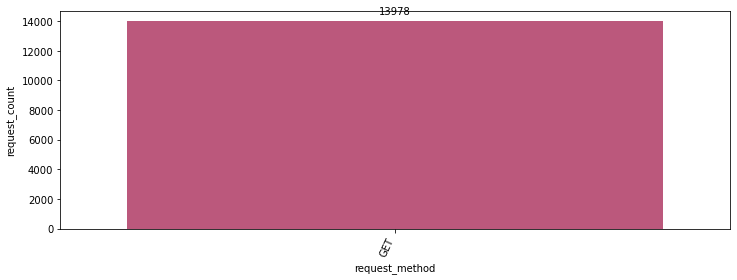

In [32]:
plt.figure(figsize=(12, 4))
splot = sns.barplot(data=request_df, x = 'request_method', y = 'request_count', ci = None, palette = 'plasma' )
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    
    plt.xticks(ha = 'right',rotation=65)

In [33]:
# find requests that happen with a 1% probability

request_df[request_df['request_proba'] <= .01]

,request_method,request_count,request_proba


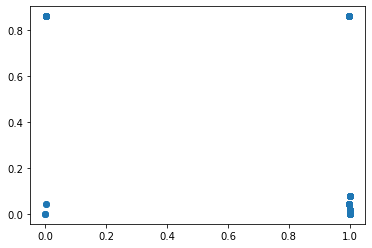

In [34]:
plt.scatter(df.proba_status_given_ip, df.ip_proba)

In [35]:
# Find request probabilites

request_df = pd.DataFrame(train.request_method.value_counts(dropna=False)/train.request_method.count()).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'method_proba'})

# merge probabilites onto original dataframe

df = df.reset_index().merge(request_df, on=['request_method'], how='left').fillna(value=0).set_index('timestamp')

In [36]:
# find request probabilities

request_probs = train.groupby('request_method').size().div(len(df))

# find probability of each status given a request method

status_given_request = pd.DataFrame(train.groupby(['request_method', 'status_code']).\
                               size().div(len(train)).\
                               div(request_probs, 
                                   axis=0, 
                                   level='request_method').\
                               reset_index().\
                               rename(index=str, 
                                      columns={0: 'proba_status_given_request'})
                              )

In [37]:
# calculate status counts by each method

request_status_count = pd.DataFrame(train.groupby(['request_method', 'status_code'])['ip'].\
                                count().reset_index().\
                                rename(index=str, 
                                       columns={'ip': 'request_method_status_count'}))

#Merge the data

request_status = status_given_request.merge(request_status_count)

In [38]:
request_status

,request_method,status_code,proba_status_given_request,request_method_status_count
0,GET,200,0.999141,13958
1,GET,499,0.001145,16


In [39]:
df = df.reset_index().merge(request_status, on=['request_method', 'status_code'], how='left').fillna(value=0).set_index('timestamp')

In [40]:
df

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb,ip_proba,proba_status_given_ip,ip_status_count,method_proba,proba_status_given_request,request_method_status_count
timestamp,,,,,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753,0.858595,0.999119,11984.0,1.0,0.999141,13958.0
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396,0.858595,0.999119,11984.0,1.0,0.999141,13958.0
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472,0.858595,0.999119,11984.0,1.0,0.999141,13958.0
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377,0.858595,0.999119,11984.0,1.0,0.999141,13958.0
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246,0.858595,0.999119,11984.0,1.0,0.999141,13958.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-17 12:55:14,97.105.19.58,GET,/api/v1/sales?page=71,HTTP/1.1,200,510166,python-requests/2.21.0,0.486532,0.858595,0.999119,11984.0,1.0,0.999141,13958.0
2019-04-21 10:02:41,95.31.18.119,GET,/api/v1/items/,HTTP/1.1,200,1153005,python-requests/2.21.0,1.099591,0.000000,0.000000,0.0,1.0,0.999141,13958.0
2019-04-17 19:36:41,95.31.16.121,GET,/api/v1/sales?page=79/,HTTP/1.1,301,1005,python-requests/2.21.0,0.000958,0.000000,0.000000,0.0,1.0,0.000000,0.0


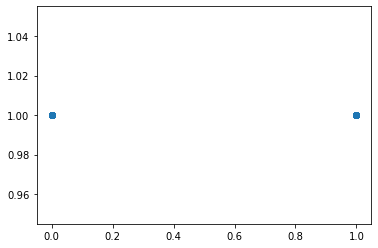

In [41]:
plt.scatter(df.proba_status_given_request, df.method_proba)